## ECE-UY 4563 Intro to Machine Learning Final Project - Dog Breed Classification 
* Presented by: Eren Tuksal(et2179@nyu.edu) and James Zhang(hz2852@nyu.edu)

In this project, we aim to develop a convolutional neural network capable of identifying 120 different dog breeds. The primary training dataset includes over 10,000 images of dogs captured from various angles and in diverse scenes. Additionally, there is a test dataset that includes not only dog images but also images of non-dog subjects, allowing us to evaluate the model's ability to differentiate between dog and non-dog images.

The following topics and techniques are covered:
* PyTorch
* Image Processing
* Transfer Learning - ResNet18 model is used


## Import Packages and ResNet18
The image processor from ResNet18 is loaded, and the classsification model will be used for transfer learning

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import skimage
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import gc
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.optim as optim
import joblib

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model and image processor
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18").to(device)


Using device: cuda


## Dog Time - Draw some dog pictures

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
(10222, 2)


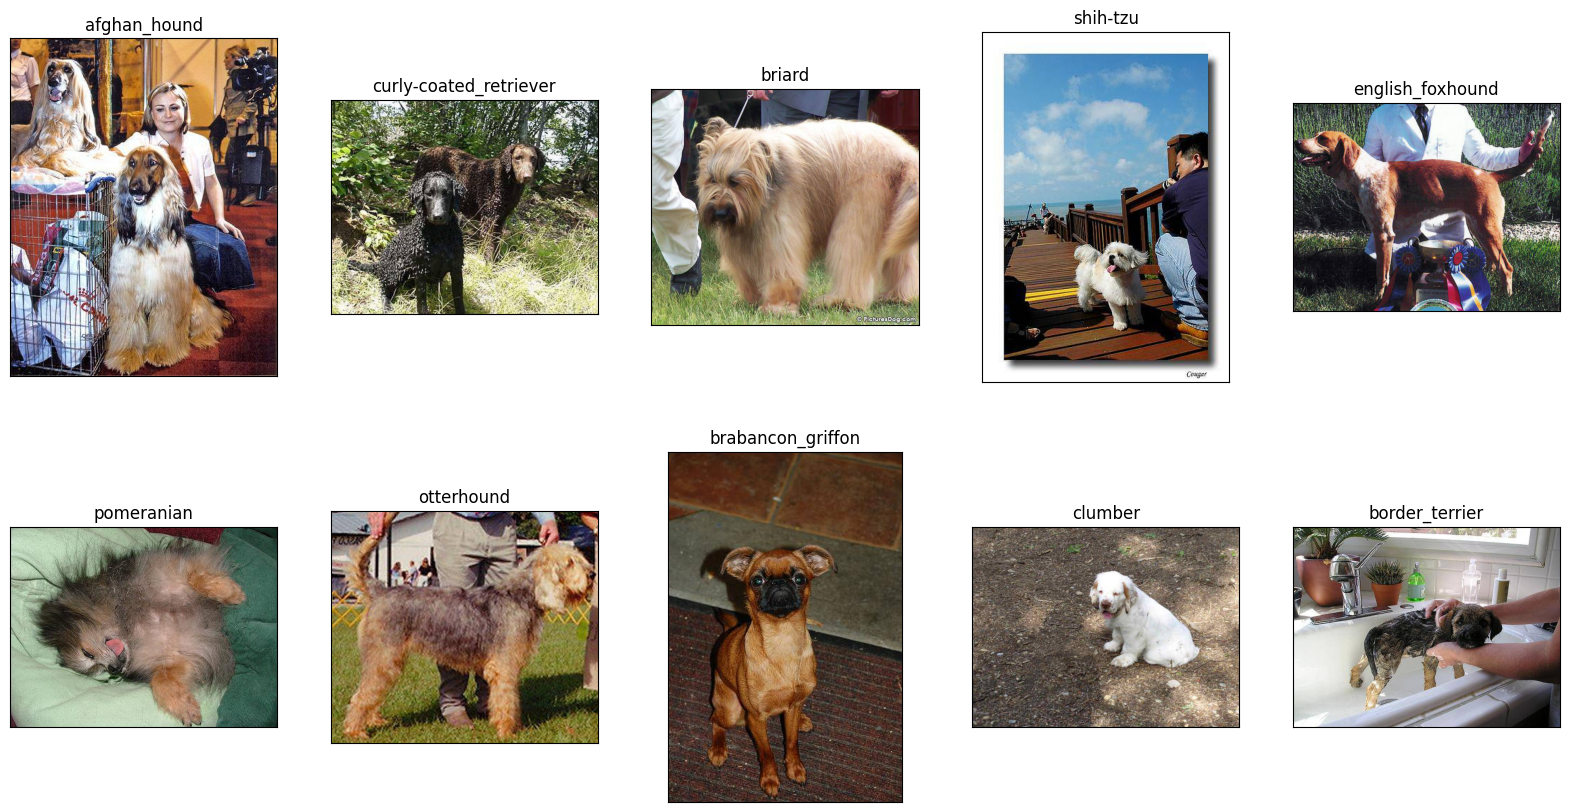

In [2]:
# Load the dataset
df = pd.read_csv('labels.csv')
print(df.head())
print(df.shape)

# Function to display images
def disp_image(im):
    im1 = (im - np.min(im)) / (np.max(im) - np.min(im)) * 255
    im1 = im1.astype(np.uint8)
    plt.imshow(im1)
    plt.xticks([])
    plt.yticks([])

plt.subplots(figsize=(20, 10))
plt.axis('off')
for i in range(10):
    plt.subplot(2, 5, i + 1)
    k = np.random.randint(low=0, high=df.shape[0])
    fname = 'train/' + df['id'][k] + '.jpg'
    im_color = skimage.io.imread(fname)
    disp_image(im_color)
    plt.title(df.loc[k, 'breed'])


## Image Preprocess
Use the image processor from ResNet18 loaded before to preprocess the pictures
* Resize all input pictures into 224*224 pixels
* Transform image files into a Pytorch tensor 
* Put all tensors (images) into a list called inputs
* We will not use image augmentation techniques as it has been proved to be harmful for this training.

In [ ]:
# Encode labels
le = preprocessing.LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])


# Preprocess images
inputs = []  # List of tensors for each image
for im in range(df.shape[0]):
    fname = 'train/' + df['id'][im] + '.jpg'
    input_image = skimage.io.imread(fname)
    input_tensor = image_processor(input_image, return_tensors="pt")["pixel_values"][0]
    inputs.append(input_tensor)

print(inputs[0].shape)  # Check the shape of the first tensor

# Create tensors for input and labels
input_batch = torch.stack(inputs).to(device)
labels = torch.tensor(df['breed'].values, dtype=torch.int64).to(device)
print(input_batch.shape)
print(labels.shape)

# Split into train and test sets
xtr, xts, ytr, yts = train_test_split(input_batch, labels, test_size=0.15, random_state=42)


torch.Size([3, 224, 224])
torch.Size([10222, 3, 224, 224])
torch.Size([10222])


## Transfer Learning 
Modify loaded ResNet18. We will substitute the last output layer with our model.
* Change the output dimension to 120, number of breeds in dataset
* Freeze all layers except the last layer
* We will not add any more dropout layer here as it has been tested to be harmful


In [4]:
# Update model for 120 classes
num_classes = 120
classifier = model.classifier[-1]  # Last layer
model.classifier[-1] = nn.Linear(classifier.in_features, num_classes)

# Freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)
print(model)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

In [5]:
# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(xtr, ytr)
test_dataset = TensorDataset(xts, yts)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Re-train the Model

In [6]:
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize lists to store metrics
train_accuracy_history = []
test_accuracy_history = []
loss_history = []

# Training loop
epochs = 15
for epoch in range(epochs):
    gc.collect()
    torch.cuda.empty_cache()

    # Training phase
    model.train()
    correct, total, epoch_loss = 0, 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.logits, target)
        loss.backward()
        optimizer.step()

        # Top-2 accuracy
        _, top2_predicted = torch.topk(outputs.logits, 2, dim=1)
        total += target.size(0)
        correct += (top2_predicted == target.unsqueeze(1)).sum().item()
        epoch_loss += loss.item()

    train_accuracy = 100 * correct / total
    train_accuracy_history.append(train_accuracy)
    loss_history.append(epoch_loss / len(train_loader))

    # Testing phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, top2_predicted = torch.topk(outputs.logits, 2, dim=1)
            total += target.size(0)
            correct += (top2_predicted == target.unsqueeze(1)).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)

    # Print epoch metrics
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'  Loss: {epoch_loss:.4f}')
    print(f'  Train Accuracy: {train_accuracy:.2f}%')
    print(f'  Test Accuracy: {test_accuracy:.2f}%\n')

    scheduler.step()

print("Training complete!")


Epoch [1/15]
  Loss: 695.8979
  Train Accuracy: 57.97%
  Test Accuracy: 81.23%

Epoch [2/15]
  Loss: 303.4460
  Train Accuracy: 86.67%
  Test Accuracy: 85.79%

Epoch [3/15]
  Loss: 224.0695
  Train Accuracy: 90.42%
  Test Accuracy: 85.92%

Epoch [4/15]
  Loss: 184.0888
  Train Accuracy: 92.02%
  Test Accuracy: 86.90%

Epoch [5/15]
  Loss: 160.2091
  Train Accuracy: 93.85%
  Test Accuracy: 88.53%

Epoch [6/15]
  Loss: 122.2008
  Train Accuracy: 96.51%
  Test Accuracy: 88.40%

Epoch [7/15]
  Loss: 118.8116
  Train Accuracy: 96.78%
  Test Accuracy: 88.40%

Epoch [8/15]
  Loss: 116.7410
  Train Accuracy: 96.59%
  Test Accuracy: 88.27%

Epoch [9/15]
  Loss: 116.2958
  Train Accuracy: 96.63%
  Test Accuracy: 89.11%

Epoch [10/15]
  Loss: 114.8814
  Train Accuracy: 97.17%
  Test Accuracy: 88.07%

Epoch [11/15]
  Loss: 109.7511
  Train Accuracy: 97.21%
  Test Accuracy: 88.46%

Epoch [12/15]
  Loss: 108.8193
  Train Accuracy: 97.24%
  Test Accuracy: 88.72%

Epoch [13/15]
  Loss: 109.3391
  Trai

# Save the Model and Plot Training History

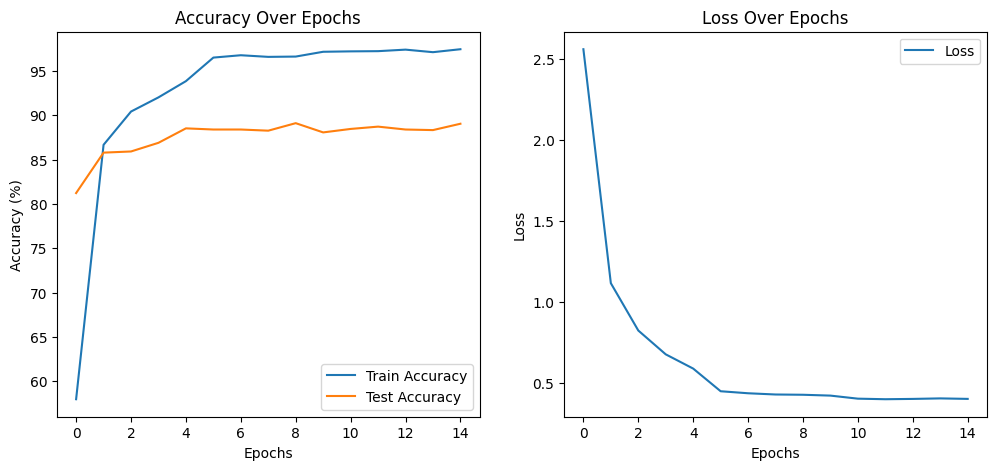

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

In [7]:
# Save model
torch.save(model, 'model_imp_v2.pth')

# Plot metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label="Train Accuracy")
plt.plot(test_accuracy_history, label="Test Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

plt.subplot(1, 2, 2)
plt.plot(loss_history, label="Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()


joblib.dump(le, 'label_encoder.pkl')

print(model)